# A First Introduction to Persistent Homology

1. Given a set of points, we build a graph whose nodes are the data points, with a neighborhood around each node, which makes some geometric shapes appear.
2. We give a topological interpretation of this structure in terms of simplices and complex, and homology groups are introduced to interpret the "shape of the original data".
3. A computational way to get the homology groups is then given.
The last step to finish the definition of "data shape" comes with persistent homology.

The references used below are:
* Fast Construction of the Vietoris-Rips Complex, by A. Zomorodian.
  This paper contains the algorithms for the Vietoris-Rips complex.
* http://outlace.com/Topological+Data+Analysis+Tutorial+-+Part+2/
  This is a blog that gives an introduction assuming no math background.
* An Introduction to Homology, by Prerna Nadathur
  Some online notes for basic definitions on simplices.
* http://people.physics.anu.edu.au/~vbr110/thesis/ch3-homology.pdf
  Some online notes for some basic reading on homology.
* http://www.math.ubc.ca/~oantolin/mathX27/smith-form.html
  A nice explanation of the role of the Smith normal form.

# Building a Graph from a Data Set

We start by generating a small set of points, on a circle, perturbed by some uniform noise. This is because our goal will be to somehow detect that we have a circle-like shape.

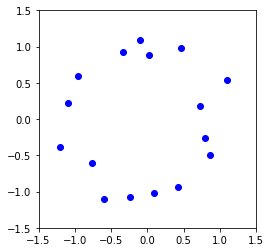

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

nbpts = 16
C = np.array([np.cos(np.linspace(0,2*math.pi,nbpts)),np.sin(np.linspace(0,2*math.pi,nbpts))])
Cn = C + np.random.uniform(-0.3,0.3,(2,nbpts))

plt.plot(Cn[0],Cn[1],'ob') 
plt.axis([-1.5,1.5,-1.5,1.5])
plt.gca().set_aspect('equal',adjustable='box')
plt.show()

We construct a neighborhood graph $G=(V,E)$ where $V$ is given by the data points, and $E$ is a function of a given parameter $\epsilon$:
$$ E = E_\epsilon = \{ (u,v),~d(u,v) \leq\epsilon \}$$ 
where the distance is the Euclidean distance. The graph $G$ is weighted, with weight function $w$ given by $w((u,v))=d(u,v)$. 

nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
edges: [[0, 1], [0, 14], [1, 14], [2, 3], [3, 4], [4, 5], [5, 6], [7, 8], [9, 10], [10, 11], [12, 13]]
weights: [0.34238566035571744, 0.30139062170085823, 0.30922057009385107, 0.32659838020541604, 0.47779096127079618, 0.48983905815737588, 0.42824312557523403, 0.44264924418719209, 0.43504969629328721, 0.49346615385025805, 0.32793796122976754]


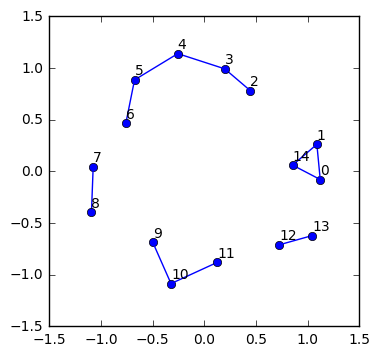

In [9]:
V = Cn.transpose()
E = []
weights = []
eps = 0.5
for i in range(0,nbpts):
    #draw and annotate nodes
    plt.plot(V[i,0],V[i,1],'ob')
    plt.annotate(i,(V[i,0],V[i,1]+0.05))
    for j in range(i+1,nbpts):
        if np.linalg.norm(V[i]-V[j]) < eps:
            E.append([i,j])
            weights.append(np.linalg.norm(V[i]-V[j]))
            plt.plot([V[i,0],V[j,0]],[V[i,1],V[j,1]],'b')

print('nodes:',[j for j in range(0,len(V))])
print('edges:', E)
print('weights:', weights)

plt.axis([-1.5,1.5,-1.5,1.5])
plt.gca().set_aspect('equal',adjustable='box')
plt.show()

Given a neighborhood graph $(G,w)$ with $G=(V,E)$ and weight $w$, the Vietoris-Rips complex $(R(G),w)$ is given by
$$R(G) = V \cup E \cup \{ \sigma \in V,~{\sigma \choose 2} \subset E\}$$
and 
$$ w=\left\{\begin{array}{ll}
0, & \sigma \in V \\
w(\sigma), & \sigma \in E \\
\max_{\tau\subset \sigma} w(\sigma) & \mbox{else}\\
\end{array}\right.
$$
In words, the set $R(G)$ contains vertices and edges from $G$, and also subsets of vertices such that any pair in this subset is connected by an edge. Then the weight function on $R(G)$ is defined to be 0 for a vertex, the weight of an edge for an edge, and for $\sigma$ a subset of vertices where every pair is connected by an edge, the weight is that of the longest edge. 
We will not use the definition of weight of the complex for a while.

To compute the Vietoris-Rips complex, Zomorodian describes the following two functions (the paper contains a proof justifying why this works).

In [1]:
def Lower_Nbrs(V,E,u):
    #find all the neighbors v of vertex u in the neighborhood graph G=(V,E) 
    #that precede it (in whichever ordering the vertices are)
    return{v for v in V if u > v and ([u,v] in E or [v,u] in E)}


In [2]:
from operator import itemgetter

def VRcomplex(D,k,eps,pltcmp):
    #inputs: the set D of data points,and k is the max dimension desired for the simplices
    #(k=0 for vertices, k=1 for edges, k=2 for triangles, thus the max for 2d plot)
    # eps = radius of the balls
    #pltcmp is 1 to see the plot

    #stores weights
    weights = []
    
    #this creates the neighborhood graph and add its vertices and edges to the complex
    #add vertices to the complex
    nb_nodes = len(D)
    VRcomplex = [[j] for j in range(0,nb_nodes)]
    #add edges
    nb_edges = 0
    for i in range(0,nb_nodes):
        for j in range(i+1,nb_nodes):
            #this is O(nb_nodes^2)
            if np.linalg.norm(D[i]-D[j]) < eps:
                VRcomplex.append([i,j])
                weights.append(np.linalg.norm(D[i]-D[j]))
                nb_edges = nb_edges + 1
        
    for i in range(1,k):
        for simplex in [v for v in VRcomplex if len(v)==i+1]:
            N = set.intersection(*[Lower_Nbrs(range(0,nb_nodes),VRcomplex[nb_nodes:nb_nodes+nb_edges],u) for u in simplex])
            for n in N:
                VRcomplex.append(sorted(list(set.union({n},simplex)),key=int))
    
    #plot complex
    if pltcmp == 1:
        for i in range(0,nb_nodes):
        #draw and annotate nodes
            plt.plot(D[i,0],D[i,1],'ob')
            plt.annotate(i,(D[i,0],D[i,1]+0.05))
        #draw edges    
        for j in range(nb_nodes,nb_nodes+nb_edges):
            plt.plot([D[VRcomplex[j][0],0],D[VRcomplex[j][1],0]],[D[VRcomplex[j][0],1],D[VRcomplex[j][1],1]],'b')
        #draw surfaces
        idx = nb_nodes+nb_edges
        
        while idx<len(VRcomplex) and len(VRcomplex[idx])==3:
            #extract triangles, and sort them according to their x components
            trg = sorted(D[VRcomplex[idx]],key=itemgetter(0))
            a = (trg[0][1]-trg[2][1])/(trg[0][0]-trg[2][0])
            b = trg[0][1]-a*trg[0][0]
            plt.fill_between([trg[j][0] for j in range(3)],[trg[j][1] for j in range(3)],[trg[0][1],a*trg[1][0]+b,trg[2][1]],color='blue',alpha='0.5')
            idx = idx+1
        plt.axis([-1.5,1.5,-1.5,1.5])
        plt.gca().set_aspect('equal',adjustable='box')
        #plt.show()
    return(VRcomplex)

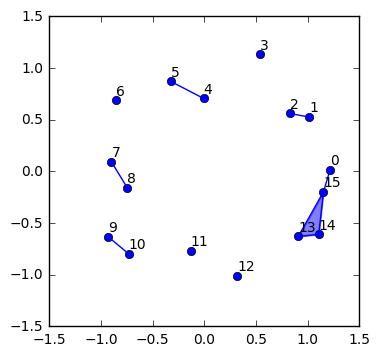

[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [0, 15], [1, 2], [4, 5], [7, 8], [9, 10], [13, 14], [13, 15], [14, 15], [13, 14, 15]]


In [5]:
V = Cn.transpose()
obt_complex = VRcomplex(V,2,0.5,1)
print(obt_complex)

We observe in the above plot the different types of components described in the Vietoris-Rips complex: points, edges, and a subset of vertices such that every pair of vertices is connected by an edge (forming here a triangle). Obviously the result depends on the choice of $\epsilon$. For example, a small $\epsilon$ typically gives a few edges (left below), while a large $\epsilon$ gives many triangles (right below).

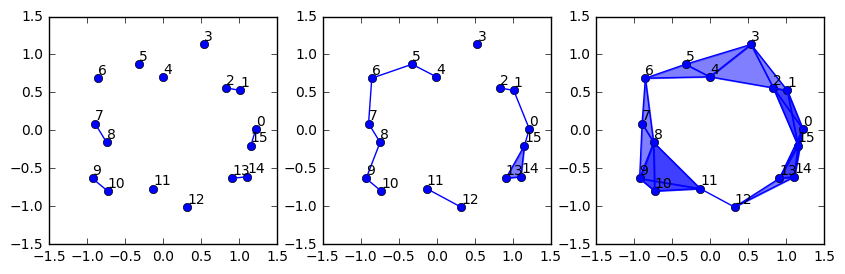

In [13]:
plt.figure(1,figsize=(10,10))
plt.subplot(131)
VRcomplex(V,2,0.3,1)
plt.subplot(132)
VRcomplex(V,2,0.6,1)
plt.subplot(133)
VRcomplex(V,2,0.9,1)
plt.show()

# Topological Background

A $k$-**simplex** $\sigma$ is the convex hull of $k+1$ affinely independent points $\{u_0,\ldots,u_k\}$. This means 
that given a set of points $\{u_0,\ldots,u_k\}$ such that the $k$ vectors $u_i-u_0$ are linearly independent for $1\leq i \leq k$, a $k$-simplex is the set 
$$
\sigma = \{ \sum_{i=0}^k\lambda_iu_i,~\sum_{i=0}^k \lambda_i=1,~\lambda_i \geq 0 \}.
$$
Then $k$ is called the **dimension** of the simplex.
For example, when $k=0$, a $0$-simplex is a point (vertex), when $k=1$, a $1$-simplex is an edge, a $2$-simplex is a triangle, a $3$-simplex is a tetrahedron. A **face** $\tau$ of $\sigma$ is the convex hull of a non-emtpy subset of the $u_i$. Since $\{u_0,\ldots,u_k\}$ contains $2^{k+1}$ subsets, $\sigma$ has $2^{k+1}-1$ faces (we exclude the empty set).

A **simplicial complex** is a finite collection $K$ of simplices such that $\sigma \in K$ and $\tau \leq \sigma$ implies $\tau \in K$ (every face belongs to $K$) and $\sigma,\sigma_0 \in K$ implies $\sigma \cap \sigma_0$ is either empty or a face of both. The **dimension** of $K$ is the maximum dimension of any of its simplices.

The above definitions are describing simplices and simplicial complexes in a Euclidean space. We have similar abstract definitions. An **abstract simplicial complex** is a finite collection $A$ of sets such that $\alpha \in A$ and $\beta \subseteq \alpha$ implies $\beta \in A$. The sets in $A$ are its simplices. The dimension of a simplex $\alpha$ is its cardinality -1, and the dimension of $A$ is the maximum dimension of any of its simplices. A **face** of a simplex $\alpha$ is a non-empty subset of $\alpha$.

We observe that the definition of Vietoris-Rips complex above fits the definition of abstract simplicial complex: vertices have only empty subsets, edges have vertices as subsets which belong to the complex, and for the component added by considering subsets of vertices such that every pair is connected by an edge, suppose that we remove one vertex from this subset, we get a new subset of vertices, where every pair is still connected by an edge, and thus it belongs to the complex. For example, if we have a triangle, we remove one vertex, we are left with two vertices connected by an edge.

Now a simplex typically comes with an orientation (an ordering of the vertices), and any even permutation of the vertices is considered as the same orientation, while another ordering obtained by an odd permutation is considered as the reversed orientation. A standard orientation is that induced by the natural ordering of the vertices.

Given a simplicial complex $K$, an **$n$-chain** is a finite formal sum of $n$-simplices of $K$, with coefficients in $\mathbb{Z}$: $\sum a_i \sigma_i$, $a_i \in \mathbb{Z}$, and $\sigma_i$ are $n$-simplices of $K$. Actually coefficients can be taken more generally in an abelian group, and $\mathbb{Z}$ is a frequent choice, which we will use for a while, though fields, and finite fields can also be used (the finite field $\mathbb{F}_2$ is preferred for persistent homology).  
The set of $n$-chains forms a group under addition, where
$$
\sum a_i \sigma_i + \sum b_i \sigma_i = \sum (a_i+b_i) \sigma_i,
$$
and $-\sigma$ is the simplex $\sigma$ with the reverse orientation.
This group is called the $n$th chain group $C_n$, it is a free group with basis given by all the $n$-simplices of $K$.

The **boundary** $\delta$ of an $n$-simplex $\sigma$ is an $(n-1)$-chain given by the formal sum of its n-1 faces: 
$$
\delta(\sigma) = \sum_{\tau} \tau
$$
where the sum is over all the subsets of $\sigma$ which are $(n-1)$-simplices.

Given an ordering $(v_0,\ldots,v_n)$, of an $n$-simplex, the orientation of an $(n-1)$ face is given by $(-1)^i(v_0,\ldots,v_{i-1},v_{i+1},\ldots,v_n)$.

In the example below, we can form 2-chains of the form $a_0[2,3,4]+a_1[3,4,5]+a_2[10,11,12]+a_3[11,12,13]+a_4[0,14,15]$, $a_0,\ldots,a_4 \in \mathbb{Z}$.

Consider the 2-simplex $[2,3,4]$.
Its boundary is $\delta([2,3,4])=[2,3]+[3,4]+[4,2]$ using that $-[2,4]=[4,2]$.

0-simplices:
[0] [1] [2] [3] [4] [5] [6] [7] [8] [9] [10] [11] [12] [13] [14] [15] 
 1-simplices:
[0, 14] [0, 15] [1, 15] [2, 3] [2, 4] [3, 4] [3, 5] [4, 5] [5, 6] [6, 7] [7, 8] [8, 9] [9, 10] [10, 11] [10, 12] [11, 12] [11, 13] [12, 13] [13, 14] [14, 15] 
 2-simplices:
[2, 3, 4] [3, 4, 5] [10, 11, 12] [11, 12, 13] [0, 14, 15]

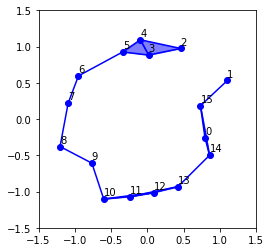

In [16]:
V = Cn.transpose()
obt_complex = VRcomplex(V,2,0.7,1)
print('0-simplices:')
idx = 0
while len(obt_complex[idx]) == 1:
    #use end="" for python3
    print(obt_complex[idx]),
    idx = idx + 1
print('\n 1-simplices:')
while len(obt_complex[idx]) == 2:
    print(obt_complex[idx]),
    idx = idx + 1    
print('\n 2-simplices:')
while idx < len(obt_complex) and len(obt_complex[idx]) == 3:
    print(obt_complex[idx]),
    idx = idx + 1   
plt.show()

An $n$-chain is an **$n$-cycle** if its boundary is 0.
The above example has two $1$-cycles, $[3,4]+[4,5]+[5,3]$, is one of them for example. Note that $[5,3]=-[3,5]$, so if we want to write the $1$-cycle in a basis where every edge has the orientation induced by the vertex ordering, we could write $[3,4]+[4,5]-[3,5]$.
The example below has several of them [there is a glitch in the code example below, [8,9,7] should be [7,8,9], the glitch got fixed but I did not recompute the example which was generated randomly]. 
Consider for example the $1$-chain given by:
$$
[10,11]+[11,13]+[13,0]+[0,1]+[1,2]+[2,5]+[5,6]+[6,7]+[7,9]+[9,10].
$$
Its boundary is computed by computing the boundary of every $1$-simplex.
Now $\delta([10,11])=[11]-[10]$, $\delta([11,13])=[13]-[11]$ and so the boundary of the $1$-chain is
$-[10]+[11]-[11]+[13]-[13]+[0]-[0]+[1]-[1]+[2]-[2]+[5]-[5]+[6]-[6]+[7]-[7]+[9]-[9]+[10]=0$.
This corresponds to the "circle with a hole" visible on the graph. Now $[11,13]+[13,12]+[12,11]$ is also a $1$-cycle, except there is "no hole inside", this is happening because this $1$-cycle is in fact the boundary of a triangle, or $2$-simplex $[11,13,12]$. So we already intuitively understand that $n$-cycles come into two categories, depending on whether they form the boundary of an $(n+1)$-simplex or not.

0-simplices:
[0] [1] [2] [3] [4] [5] [6] [7] [8] [9] [10] [11] [12] [13] [14] [15] 
 1-simplices:
[0, 1] [0, 13] [0, 14] [0, 15] [1, 2] [1, 15] [2, 3] [2, 4] [2, 5] [2, 15] [3, 4] [3, 5] [4, 5] [5, 6] [6, 7] [7, 8] [7, 9] [8, 9] [9, 10] [9, 11] [10, 11] [10, 12] [11, 12] [11, 13] [12, 13] [13, 14] [14, 15] 
 2-simplices:
[0, 1, 15] [1, 2, 15] [2, 3, 4] [2, 3, 5] [2, 4, 5] [3, 4, 5] [8, 9, 7] [9, 10, 11] [10, 11, 12] [11, 12, 13] [0, 13, 14] [0, 14, 15]

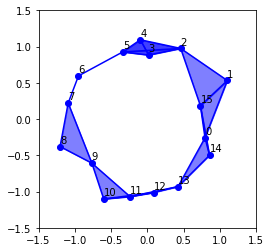

In [17]:
V = Cn.transpose()
obt_complex = VRcomplex(V,2,0.9,1)
print('0-simplices:')
idx = 0
while len(obt_complex[idx]) == 1:
    print(obt_complex[idx]),
    idx = idx + 1
print('\n 1-simplices:')
while len(obt_complex[idx]) == 2:
    print(obt_complex[idx]),
    idx = idx + 1    
print('\n 2-simplices:')
while idx < len(obt_complex) and len(obt_complex[idx]) == 3:
    print(obt_complex[idx]),
    idx = idx + 1   
plt.show()

We have that $n$-cycles form a subgroup of $n$-chains. This is clear, mostly because the boundary map $\delta$ extends by linearity, thus the sum of two $n$-cycles will have for boundary the sum of the two boundaries. If we consider $\delta=\delta_n$ as a map from the group of $n$-chains to the group of $(n-1)$-chains, we have that the subgroup of $n$-cycles is the kernel of $\delta_n$. If we denote the group of $n$-cycles as $Z_n$, we have $Z_n = Ker(\delta_n)$.
Furthermore, it can be shown that the boundary of a boundary is always zero. This tells us that boundaries of $(n+1)$-simplices form a subgroup $B_n$ of $Z_n$. Note that $B_n = Im(\delta_{n+1})$. We thus can define **the $n$th homology group $H_n$ ** given by
$$
H_n = Z_n/B_n.
$$
The elements of $H_n$ are thus equivalence classes of $n$-cycles that do not bound any $(n+1)$-chain. This quotient reconciles us with the above intuition: among the $n$-cycles, some of them are boundary of $(n+1)$ simplices, which are those we are "not interested in", while the others correspond to "holes", thus yielding a homological way to characterize $n$-dimensional holes.

It turns out that $H_n$ has a structure of finitely generated abelian group, more precisely
$$
H_n \simeq (\mathbb{Z} \oplus \ldots \oplus \mathbb{Z}) \oplus \mathbb{Z}/t_1 \oplus \ldots \oplus \mathbb{Z}/t_m.
$$
The number of copies of $\mathbb{Z}$ is called the **Betti number**. The cyclic groups $\mathbb{Z}/t_i$ are the torsion subgroups. 
* When $n=0$, we have that $H_0 = C_0/B_0$, because every vertex has a boundary which is $0$. The quotient by $B_0$ means that we are looking at $0$-chains modulo edges, thus we are counting the number of path-connected components of the space.
* When $n=1$, we are looking at $1$-chains modulo those that are the boundaries of $2$-simplices, so we are left with holes.

Consider the example below, with boundary maps 
$$\delta_2: C_2 \rightarrow C_1,~ \delta_1: C_1 \rightarrow C_0,~ \delta_0: C_0 \rightarrow 0,$$ 
where $C_2$ contains $2$-chains (generated by triangles), $C_1$ contains $1$-chains (generated by edges) and $C_0$ contains $0$-chains (generated by vertices). A basis for $C_0$ is $\{[0],[1],[2],[3],[4]\}$, one for $C_1$ is $\{[0,1],[4,0],[2,1],[1,4],[3,2],[4,3] \}$, by choosing one orientation (which is not the natural one), and $\delta_1$ maps $b_0[0,1]+b_1[4,0]+b_2[2,1]+b_3[1,4]+b_4[3,2]+b_5[4,3]$ to $[0](-b_0+b_1)+[1](b_0+b_2-b_3)+[2](-b_2+b_4)+[3](-b_4+b_5)+[4](-b_1+b_3-b_5)$. Thus the kernel of $\delta_1$ is 2-dimensional ($(b_1,b_1,b_2,b_1+b_2,b_2,b_2)$) .
This is clearly seen on the example below: the coefficients $b_1$ correspond to the $1$-cycle $[0,1]+[1,4]+[4,0]$. The coefficient $b_2$ corresponds to the $1$-cycle $[1,4]+[4,3]+[3,2]+[2,1]$ and the term $b_1+b_2$ reflects the edge $[1,4]$ being used twice.

Since the rank-nullity theorem holds fore free $\mathbb{Z}$-module, the image of $\delta_1$ is 4-dimensional.
Thus $Ker(\delta_0)=C_0$ has dimension 5, $Im(\delta_1)$ has dimension 4 and 
$$
H_0 = Ker(\delta_0)/Im(\delta_1) \simeq \mathbb{Z}.
$$
This gives a corresponding Betti number of 1, corresponding to a single connected component.

Next $Im(\delta_2)$ is $\delta_2([0,1,4])=[1,4]-[0,4]+[0,1]$ which gives a dimension 1, and since $Ker(\delta_1)$ has dimension 2, we have
$$
H_1 = Ker(\delta_1)/Im(\delta_2) \simeq \mathbb{Z}.
$$
The corresponding Better number is 1, for one hole.
Finally 
$$
H_2 = 0
$$
because $Ker(\delta_2)=0$ ($a_0[0,1,4]$ has a boundary of $0$ only when $a_0=0$).

0-simplices:
[0] [1] [2] [3] [4] 
 1-simplices:
[0, 1] [0, 4] [1, 2] [1, 4] [2, 3] [3, 4] 
 2-simplices:
[0, 1, 4]

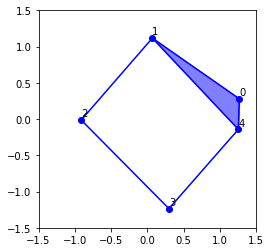

In [18]:
nbpts = 5
C5 = np.array([np.cos(np.linspace(0,2*math.pi,nbpts)),np.sin(np.linspace(0,2*math.pi,nbpts))])
Cn5 = C5 + np.random.uniform(-0.3,0.3,(2,nbpts))

V5 = Cn5.transpose()
obt_complex = VRcomplex(V5,2,1.8,1)
print('0-simplices:')
idx = 0
while len(obt_complex[idx]) == 1:
    print(obt_complex[idx]),
    idx = idx + 1
print('\n 1-simplices:')
while len(obt_complex[idx]) == 2:
    print(obt_complex[idx]),
    idx = idx + 1    
print('\n 2-simplices:')
while idx < len(obt_complex) and len(obt_complex[idx]) == 3:
    print(obt_complex[idx]),
    idx = idx + 1   
plt.show()

If we go back to our original example of a noisy circle, computing the first two Betti numbers gives us a way to compute that the shape we have is actually looking like a circle (a single path-connected component with a hole inside). Now for this approach to make sense, we need a computational way to compute these Betti numbers.

# Computing Homology Groups

Let us look again at a small example with 5 vertices.

0-simplices:
[0][1][2][3][4]
 1-simplices:
[0, 1][0, 3][0, 4][1, 2][1, 4][2, 3][3, 4]
 2-simplices:
[0, 1, 4][0, 3, 4]

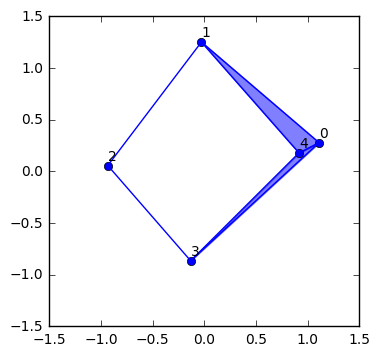

In [16]:
import numpy as np
import math
import matplotlib.pyplot as plt

nbpts = 5
C5 = np.array([np.cos(np.linspace(0,2*math.pi,nbpts)),np.sin(np.linspace(0,2*math.pi,nbpts))])
Cn5 = C5 + np.random.uniform(-0.3,0.3,(2,nbpts))

V5 = Cn5.transpose()
obt_complex = VRcomplex(V5,2,1.7,1)
print('0-simplices:')
idx = 0
while len(obt_complex[idx]) == 1:
    print(obt_complex[idx],end="")
    idx = idx + 1
print('\n 1-simplices:')
while len(obt_complex[idx]) == 2:
    print(obt_complex[idx],end="")
    idx = idx + 1    
print('\n 2-simplices:')
while idx < len(obt_complex) and len(obt_complex[idx]) == 3:
    print(obt_complex[idx],end="")
    idx = idx + 1   
plt.show()

A generic $1$-chain in $C_1$ is of the form $a_0[0,1]+a_1[0,3]+a_2[0,4]+a_3[1,2]+a_4[1,4]+a_5[2,3]+a_6[3,4]$. In the basis $\{[0,1],[0,3],[0,4],[1,2],[1,4],[2,3],[3,4]\}$, this $1$-chain can be represented by the vector
$$
\begin{bmatrix}
a_0\\
a_1 \\
a_2\\
a_3 \\
a_4 \\
a_5 \\
a_6 \\
\end{bmatrix}.
$$
When computing the boundary $\delta_1:C_1 \rightarrow C_0$, we actually just need to compute it on the basis elements, for e.g., $\delta_1([0,1])=[1]-[0]$, which can written in a basis $\{[0],[1],[2],[3],[4] \}$ of $C_0$ as 
$$
\begin{bmatrix}
-1\\
1 \\
0 \\
0 \\
0 \\
\end{bmatrix}.
$$
Iterating the same computation for other basis elements gives 
$$
\begin{array}{l|lllll}
    & [0, 1] & [0, 3] & [0, 4] & [1, 2] & [1, 4] & [2, 3] & [3, 4] \\
\hline
[0] & -1&-1&-1& 0& 0& 0& 0 \\
[1] &  1& 0& 0&-1&-1& 0& 0\\
[2] &  0& 0& 0& 1& 0&-1& 0\\
[3] &  0& 1& 0& 0& 0& 1&-1 \\
[4] &  0& 0& 1& 0& 1& 0& 1 \\
\end{array}
\begin{bmatrix}
a_0\\
a_1 \\
a_2\\
a_3 \\
a_4 \\
a_5 \\
a_6 \\
\end{bmatrix}
=
\begin{bmatrix}
-a_0-a_1-a_2\\
a_0-a_3-a_4 \\
a_3-a_5\\
a_1+a_5-a_6 \\
a_2+a_4+a_6 \\
\end{bmatrix}
$$
Then consider a $1$-chain, say $[1,4]+[4,0]+[0,1]$, which corresponds to the vector $(1,0,-1,0,1,0,0)$. Multiplication by the boundary matrix gives:
$$
\begin{bmatrix}
0 \\
0 \\
0 \\
0 \\
0 \\
\end{bmatrix}
$$
and it computes the boundary of the $1$-chain, as expected. Take instead the $1$-chain $[1,2]+[2,3]$, then the above matrix multiplication gives
$$
\begin{bmatrix}
0 \\
-1 \\
0 \\
1 \\
0 \\
\end{bmatrix}
$$
telling us that the boundary is $-[1],[3]$. Everything is basically the same as writing a linear map as a matrix once a basis is given, except that here we have a finitely generated free abelian group.

So given maps $C_{n+1} \xrightarrow{\delta_{n+1}} C_{n}  \xrightarrow{\delta_{n}} C_{n-1} $, we have that $\delta_n$ and $\delta_{n+1}$ can be written as matrices with coefficients $0,1,-1$, and we recall the property $\delta_n\delta_{n+1}=0$. Now this latter property allows $\delta_n$ to descend to a homorphism $\bar{\delta}_n: C_n/Im(\delta_{n+1}) \rightarrow C_{n-1}$, $x+Im(\delta_{n+1}) \mapsto \delta_{n}(x)$ which is thus well defined. Its kernel $Ker(\bar{\delta}_n) = \{ x+Im(\delta_{n+1}),~\delta_{n}(x)=0\}$ is thus isomorphic to $Ker(\delta_n)/Im(\delta_{n+1})$, the homology group $H_n$ we are interested in. 

Write $\delta_{n+1}$ as a matrix (we will still call it $\delta_{n+1}$ by abuse of language), and consider its Smith normal form $UDV$ where $D_{ij}=0$ whenever $i\neq j$. There are $r$ non-zero coefficients $D_{ii}=a_i$, $i=1,\ldots,r$, where $r$ is the rank of $\delta_{n+1}$, they are called the elementary divisors of $\delta_{n+1}$ and satisfy $a_i|a_{i+1}$.
Then the cokernel of $\delta_{n+1}$ is isomorphic to that of $D$. The isomorphism is given by the map
$ coker(\delta_{n+1})=C_n/Im(\delta_{n+1}) \rightarrow coker(D)=C_n/Im(D)$, $x+Im(\delta_{n+1})\mapsto U^{-1}x+Im(D)$.
But the cokernel of $D$ is much easier to compute: say the dimension of $C_n$ is $m$, then $C_n \simeq \mathbb{Z}^m$ and $Im(D)$ is spanned by $a_1e_1,\ldots,a_re_r$ (for $e_1,\ldots,e_r$ some basis of $\mathbb{Z}$, say the standard one).
Then 
$$
coker(\delta_{n+1}) \simeq coker(D) \simeq  \bigoplus_{i=1}^r\mathbb{Z}/a_i\mathbb{Z}  \oplus \mathbb{Z}^{m-r}.
$$
But since the target of $\bar{\delta}_{n}$ is free, all the torsion of $C_n/Im(\delta_{n+1})$ must be in its kernel 
$Ker(\bar{\delta}_{n}) \simeq H_n$, so we have that
$$
Ker(\bar{\delta}_{n}) \simeq \bigoplus_{i=1}^r \mathbb{Z}/a_i\mathbb{Z} \oplus Ker(\bar{\delta_{n}}|_{\mathbb{Z}^{m-r}}).
$$
Since any subgroup of a free abelian group is free, the kernel of the restriction to $\mathbb{Z}^{m-r}$ is free, and its rank is $m-r-s$, where $s$ is the rank of $Im(\delta_{n})=Im(\bar{\delta}_{n})=Im(\bar{\delta_{n}}|_{\mathbb{Z}^{m-r}})$. This finally shows that
$$
H_n \simeq \bigoplus_{i=1}^r \mathbb{Z}/a_i\mathbb{Z} \oplus \mathbb{Z}^{m-r-s}.
$$


The above computations give an algorithm. To compute $H_n$, find a matrix representation of $\delta_{n+1}$, compute its Smith normal form to obtain a "diagonal" matrix $D$ with $r$ non-zero coefficients $a_1,\ldots,a_r$. Compute the rank $s$ of the matrix $\delta_n$, which gives the dimension of $Im(\delta_n)$. Then the $a_i$ give the torsion coefficients, and $m-r-s$ gives the corresponding Betti number. 

Consider the above example, $C_{2} \xrightarrow{\delta_{2}} C_{1}  \xrightarrow{\delta_{1}} C_{0}  \xrightarrow{\delta_{0}} 0 $.
The matrix for $\delta_1$ is
$$
\delta_1=
\begin{bmatrix}
-1&-1&-1& 0& 0& 0& 0 \\
 1& 0& 0&-1&-1& 0& 0\\
 0& 0& 0& 1& 0&-1& 0\\
 0& 1& 0& 0& 0& 1&-1 \\
 0& 0& 1& 0& 1& 0& 1 \\
\end{bmatrix}
$$
We thus need a way to generate this matrix from the data set, and a way to compute its Smith normal form.

In [3]:
def BoundMatrix(complex,n):
    #take as input a complex given as a list of its simplices, and the dimension n such that we compute the (n-1)-boundary
    #which is given as a matrix with columns indexed by n-simplices
    
    nsimplex = [simplex for simplex in complex if len(simplex)==n]
    nbcols = len(nsimplex)
    n_1simplex = [simplex for simplex in complex if len(simplex)==n-1]
    nbrows = len(n_1simplex)
    
    B = np.zeros((nbrows,nbcols), dtype = np.int8)
    for i in range(0,nbcols):
        simplex = nsimplex[i]
        for j in range(0,len(simplex)):
            n_1newsimplex = [x for x in simplex if x != simplex[j]]
            B[n_1simplex.index(n_1newsimplex),i] = (-1)**j
    return B

In [4]:
def specSNF(M):
    #take as input a matrix with coefficients in 0,1,-1 and output the diagonal matrix of the Smith Normal Form
    
    nbrows = len(M)
    nbcols = len(M[0,:])
    
    cnt = 0
    piv = 0
    
    while cnt < 2:
        #row operations
        for i in range(0,nbcols):
            #look for a nonzero coefficient
            lead = M[:,i].nonzero()[0]
            lead = [idx for idx in lead if idx >= piv]
            
            #if no nonzero coefficient is found on or below the diagonal, move to the next column
            if len(lead) > 0:
                #put the row with leading coeff on the diagonal
                M[[piv,lead[0]],:] = M[[lead[0],piv],:]
                #put zeros below the diagonal
                for j in lead[1:len(lead)]:
                    M[j,:] = M[j,:]-M[piv,:]*M[j,i]/M[piv,i]
                piv = piv +1
            
        cnt = cnt + 1
        piv = 0
        nbcols = len(M)
        M = M.transpose()
    nbcols = len(M[0,:])
    for i in range(0,min(nbrows,nbcols)):
        M[i,i] = abs(M[i,i])
    return(M)
            
    

So we are now ready to go back to our example, with $C_{2} \xrightarrow{\delta_{2}} C_{1}  \xrightarrow{\delta_{1}} C_{0}  \xrightarrow{\delta_{0}} 0 $. 
* for $H_0$, we compute the Smith Normal Form of $\delta_1$, to obtain its rank $r_1$, then the corresponding Betti number is $dim(C_0)-r_1$.
* for $H_1$, we compute the Smith Normal Form of $\delta_2$, to obtain its rank $r_2$, the the corresponding Betti number is $dim(C_1)-r_2-r_1$
* for $H_2$, the Betti number is $dim(C_2)-r_2$.


0-simplices:
[0][1][2][3][4]
 1-simplices:
[0, 1][0, 3][0, 4][1, 2][1, 4][2, 3][3, 4]
 2-simplices:
[0, 1, 4][0, 3, 4]

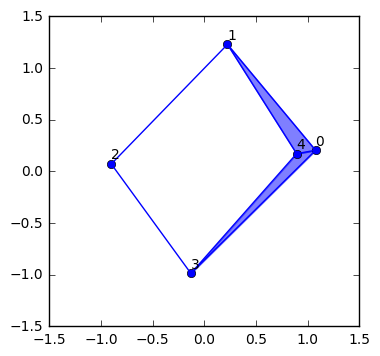

boundary matrix for delta2: 

[[ 1  0]
 [ 0  1]
 [-1 -1]
 [ 0  0]
 [ 1  0]
 [ 0  0]
 [ 0  1]]
[[1 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]]
boundary matrix for delta1: 

[[-1 -1 -1  0  0  0  0]
 [ 1  0  0 -1 -1  0  0]
 [ 0  0  0  1  0 -1  0]
 [ 0  1  0  0  0  1 -1]
 [ 0  0  1  0  1  0  1]]
[[1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]]


In [42]:
import numpy as np
import math
import matplotlib.pyplot as plt

nbpts = 5
C5 = np.array([np.cos(np.linspace(0,2*math.pi,nbpts)),np.sin(np.linspace(0,2*math.pi,nbpts))])
Cn5 = C5 + np.random.uniform(-0.3,0.3,(2,nbpts))

V5 = Cn5.transpose()
obt_complex = VRcomplex(V5,2,1.7,1)
obt_B3 = BoundMatrix(obt_complex,3)
obt_B2 = BoundMatrix(obt_complex,2)

print('0-simplices:')
idx = 0
while len(obt_complex[idx]) == 1:
    print(obt_complex[idx],end="")
    idx = idx + 1
print('\n 1-simplices:')
while len(obt_complex[idx]) == 2:
    print(obt_complex[idx],end="")
    idx = idx + 1    
print('\n 2-simplices:')
while idx < len(obt_complex) and len(obt_complex[idx]) == 3:
    print(obt_complex[idx],end="")
    idx = idx + 1   
plt.show()
print('boundary matrix for delta2: \n')
print(np.matrix(obt_B3))
print(specSNF(obt_B3))
print('boundary matrix for delta1: \n')
print(obt_B2)
print(specSNF(obt_B2))

* For $H_0$, $dim(C_0)-r_1 = 5 - 4 = 1$, for a Betti number of 1, meaning one connected component.
* For $H_1$, $dim(C_1)-r_2-r_1 = 7 -2-4=1$, for a Betti number of 1, meaning one hole.
* For $H_2$, $dim(C_2)-r_2 =2 -2=0$, since there is no higher dimensional hole.

Here is another example.

0-simplices:
[0][1][2][3][4]
 1-simplices:
[0, 1][0, 3][0, 4][1, 2][1, 4][3, 4]
 2-simplices:
[0, 1, 4][0, 3, 4]

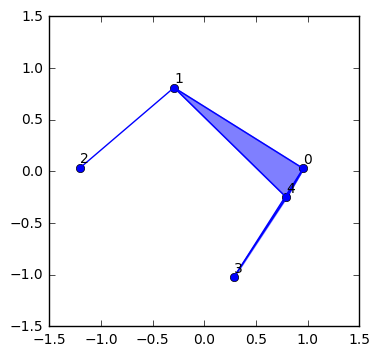

boundary matrix for delta2: 

[[ 1  0]
 [ 0  1]
 [-1 -1]
 [ 0  0]
 [ 1  0]
 [ 0  1]]
[[1 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]]
boundary matrix for delta1: 

[[-1 -1 -1  0  0  0]
 [ 1  0  0 -1 -1  0]
 [ 0  0  0  1  0  0]
 [ 0  1  0  0  0 -1]
 [ 0  0  1  0  1  1]]
[[1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 0 0]]


In [45]:
nbpts = 5
C5 = np.array([np.cos(np.linspace(0,2*math.pi,nbpts)),np.sin(np.linspace(0,2*math.pi,nbpts))])
Cn5 = C5 + np.random.uniform(-0.3,0.3,(2,nbpts))

V5 = Cn5.transpose()
obt_complex = VRcomplex(V5,2,1.7,1)
obt_B3 = BoundMatrix(obt_complex,3)
obt_B2 = BoundMatrix(obt_complex,2)

print('0-simplices:')
idx = 0
while len(obt_complex[idx]) == 1:
    print(obt_complex[idx],end="")
    idx = idx + 1
print('\n 1-simplices:')
while len(obt_complex[idx]) == 2:
    print(obt_complex[idx],end="")
    idx = idx + 1    
print('\n 2-simplices:')
while idx < len(obt_complex) and len(obt_complex[idx]) == 3:
    print(obt_complex[idx],end="")
    idx = idx + 1   
plt.show()
print('boundary matrix for delta2: \n')
print(np.matrix(obt_B3))
print(specSNF(obt_B3))
print('boundary matrix for delta1: \n')
print(obt_B2)
print(specSNF(obt_B2))

* For $H_0$, $dim(C_0)-r_1 = 5 - 4 = 1$, for a Betti number of 1, meaning one connected component.
* For $H_1$, $dim(C_1)-r_2-r_1 = 6-2-4=0$, for a Betti number of 0, meaning no hole.
* For $H_2$, $dim(C_2)-r_2 =2 -2=0$, since there is no higher dimensional hole.

We compute a 3rd example.

0-simplices:
[0][1][2][3][4]
 1-simplices:
[0, 1][0, 3][0, 4][1, 4][3, 4]
 2-simplices:
[0, 1, 4][0, 3, 4]

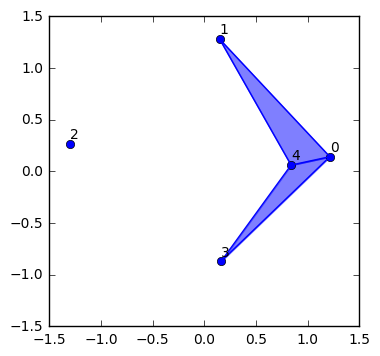

boundary matrix for delta2: 

[[ 1  0]
 [ 0  1]
 [-1 -1]
 [ 1  0]
 [ 0  1]]
[[1 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]]
boundary matrix for delta1: 

[[-1 -1 -1  0  0]
 [ 1  0  0 -1  0]
 [ 0  0  0  0  0]
 [ 0  1  0  0 -1]
 [ 0  0  1  1  1]]
[[1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


In [47]:
nbpts = 5
C5 = np.array([np.cos(np.linspace(0,2*math.pi,nbpts)),np.sin(np.linspace(0,2*math.pi,nbpts))])
Cn5 = C5 + np.random.uniform(-0.3,0.3,(2,nbpts))

V5 = Cn5.transpose()
obt_complex = VRcomplex(V5,2,1.7,1)
obt_B3 = BoundMatrix(obt_complex,3)
obt_B2 = BoundMatrix(obt_complex,2)

print('0-simplices:')
idx = 0
while len(obt_complex[idx]) == 1:
    print(obt_complex[idx],end="")
    idx = idx + 1
print('\n 1-simplices:')
while len(obt_complex[idx]) == 2:
    print(obt_complex[idx],end="")
    idx = idx + 1    
print('\n 2-simplices:')
while idx < len(obt_complex) and len(obt_complex[idx]) == 3:
    print(obt_complex[idx],end="")
    idx = idx + 1   
plt.show()
print('boundary matrix for delta2: \n')
print(np.matrix(obt_B3))
print(specSNF(obt_B3))
print('boundary matrix for delta1: \n')
print(obt_B2)
print(specSNF(obt_B2))

* For $H_0$, $dim(C_0)-r_1 = 5 - 3 = 2$, for a Betti number of 2, meaning two connected components.
* For $H_1$, $dim(C_1)-r_2-r_1 = 5-2-3=0$, for a Betti number of 0, meaning no hole.
* For $H_2$, $dim(C_2)-r_2 =2 -2=0$, since there is no higher dimensional hole.
Let us go back to an example with more points.

0-simplices:
[0] [1] [2] [3] [4] [5] [6] [7] [8] [9] [10] [11] [12] [13] [14] [15] 
 1-simplices:
[0, 1] [0, 14] [0, 15] [1, 2] [1, 3] [1, 14] [1, 15] [2, 3] [2, 5] [3, 5] [4, 5] [4, 6] [5, 6] [6, 7] [6, 8] [7, 8] [8, 9] [8, 10] [9, 10] [9, 11] [10, 11] [11, 12] [11, 13] [12, 13] [13, 14] [14, 15] 
 2-simplices:
[0, 1, 14] [0, 1, 15] [1, 2, 3] [2, 3, 5] [4, 5, 6] [6, 7, 8] [8, 9, 10] [9, 10, 11] [11, 12, 13] [0, 14, 15] [1, 14, 15] 
 3-simplices:
[0, 1, 14, 15]

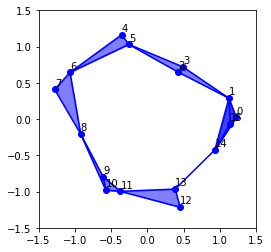

 Betti number for H0:
1
Betti number for H1:
1
Betti number for H2:
1


In [37]:
nbpts = 16

#computes data set
C = np.array([np.cos(np.linspace(0,2*math.pi,nbpts)),np.sin(np.linspace(0,2*math.pi,nbpts))])
Cn = C + np.random.uniform(-0.3,0.3,(2,nbpts))
V = Cn.transpose()

#computes the corresponding complex
obt_complex = VRcomplex(V,3,0.9,1)

#compute delta2
obt_B3 = specSNF(BoundMatrix(obt_complex,3))
r2 = len(obt_B3.nonzero()[0])
#compute delta1
obt_B2 = specSNF(BoundMatrix(obt_complex,2))
r1 = len(obt_B2.nonzero()[0])

print('0-simplices:')
idx = 0
while len(obt_complex[idx]) == 1:
    print(obt_complex[idx]),#end="")
    idx = idx + 1
dimC0 = idx

print('\n 1-simplices:')
while len(obt_complex[idx]) == 2:
    print(obt_complex[idx]),#end="")
    idx = idx + 1    
dimC1 = idx - dimC0

print('\n 2-simplices:')
while idx < len(obt_complex) and len(obt_complex[idx]) == 3:
    print(obt_complex[idx]),#end="")
    idx = idx + 1  
dimC2 = idx - dimC1 - dimC0    

print('\n 3-simplices:')
while idx < len(obt_complex) and len(obt_complex[idx]) == 4:
    print(obt_complex[idx]),#end="")
    idx = idx + 1  

plt.show()

print('Betti number for H0:')
print(dimC0 - r1)
print('Betti number for H1:')
print(dimC1 - r2 - r1)
print('Betti number for H2:')
print(dimC2 - r2)


So for this example, the first Betti is 1 because there is one connected component, the second Betti number is 1, because there is one hole, and the 3rd Betti number is 1, because it corresponds to the empty space inside of the tetrahedron $[0,1,14,15]$.

We have finally (almost) answered the original question. Given a set of noisy points, we get three Betti numbers, telling us that we have a single connected component, with a hole inside, and we also detect the presence of a tetrahedron. The question is almost answered, because we get this result for a given choice of $\epsilon$ which defines our neighborhood.

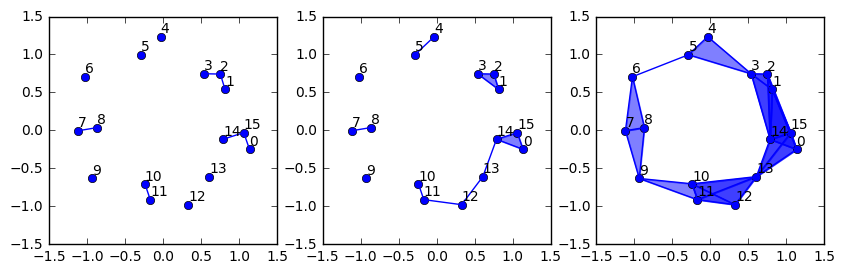

Betti numbers for simplex 0
10
0
0
Betti numbers for simplex 1
6
0
0
Betti numbers for simplex 2
1
1
5


In [6]:
import numpy as np
import math
import matplotlib.pyplot as plt

nbpts = 16

#computes data set
C = np.array([np.cos(np.linspace(0,2*math.pi,nbpts)),np.sin(np.linspace(0,2*math.pi,nbpts))])
Cn = C + np.random.uniform(-0.3,0.3,(2,nbpts))
V = Cn.transpose()

plt.figure(1,figsize=(10,10))
obt_complex = []
eps = [0.3,0.6,0.9]
#computes the corresponding complex with epsilon varying
plt.subplot(131)
obt_complex.append(VRcomplex(V,3,eps[0],1))
plt.subplot(132)
obt_complex.append(VRcomplex(V,3,eps[1],1))
plt.subplot(133)
obt_complex.append(VRcomplex(V,3,eps[2],1))
plt.show()

dimC0 = len([simplex for simplex in obt_complex[0] if len(simplex)==1])
dimC1 = []
dimC2 = []
r = np.zeros((3,2),dtype=np.int8)

for i in range(0,3):
    dimC1.append(len([simplex for simplex in obt_complex[i] if len(simplex)==2]))
    dimC2.append(len([simplex for simplex in obt_complex[i] if len(simplex)==3]))
    print('Betti numbers for simplex',i)
    for j in range(0,2):
        #compute delta1 and delta2
        obt_Bij = specSNF(BoundMatrix(obt_complex[i],j+2))
        r[i,j] = len(obt_Bij.nonzero()[0])
    print(dimC0 - r[i,0])
    print(dimC1[i] - r[i,1] - r[i,0])
    print(dimC2[i] - r[i,1])


The point of persistent homology is to look at the behaviour of homology groups and Betti numbers in particular, as a function of $\epsilon$, to see which features "persist" when $\epsilon$ varies.